In [ ]:
import math
import numpy as np
import os
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import pandas_datareader as pdr
from datetime import datetime, timedelta

In [ ]:
import yfinance as yf

ticker = "AAPL"  # Apple Inc. instead of SBUX
start_date = "2018-01-01"
end_date = "2023-11-27"

stock_df = yf.download(ticker, start=start_date, end=end_date)
print("Shape of df after download:", stock_df.shape)
print(stock_df.head())

[*********************100%***********************]  1 of 1 completed

Shape of df after download: (1485, 6)
Price                      Adj Close      Close       High        Low  \
Ticker                          AAPL       AAPL       AAPL       AAPL   
Date                                                                    
2018-01-02 00:00:00+00:00  40.524349  43.064999  43.075001  42.314999   
2018-01-03 00:00:00+00:00  40.517292  43.057499  43.637501  42.990002   
2018-01-04 00:00:00+00:00  40.705494  43.257500  43.367500  43.020000   
2018-01-05 00:00:00+00:00  41.168934  43.750000  43.842499  43.262501   
2018-01-08 00:00:00+00:00  41.016018  43.587502  43.902500  43.482498   

Price                           Open     Volume  
Ticker                          AAPL       AAPL  
Date                                             
2018-01-02 00:00:00+00:00  42.540001  102223600  
2018-01-03 00:00:00+00:00  43.132500  118071600  
2018-01-04 00:00:00+00:00  43.134998   89738400  
2018-01-05 00:00:00+00:00  43.360001   94640000  
2018-01-08 00:00:00+00:00  

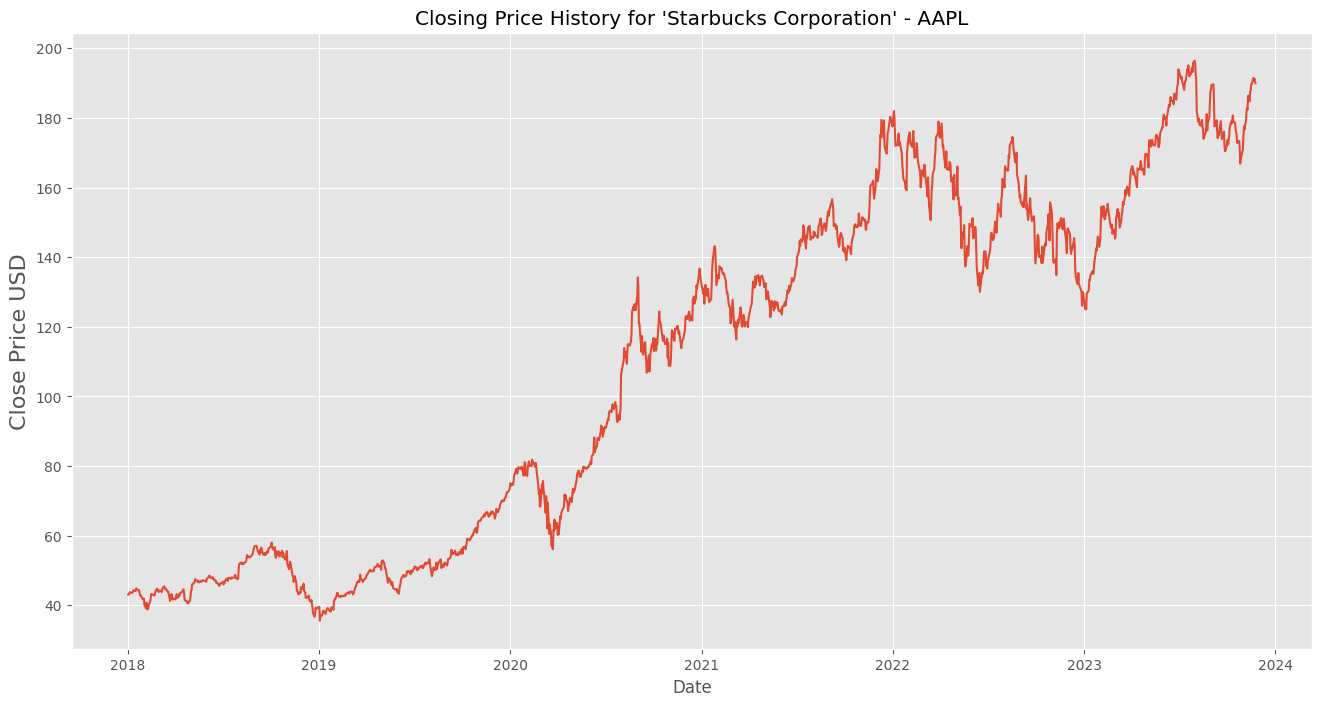

In [ ]:
# Visualize closing price history
plt.figure(figsize=(16,8))
plt.title (f"Closing Price History for '{stock}' - {ticker}")
plt.plot(stock_df['Close'])
plt.xlabel('Date')
plt.ylabel('Close Price USD', fontsize=16)
plt.savefig('../content/Images/his_'+ticker+'.png')
plt.show()

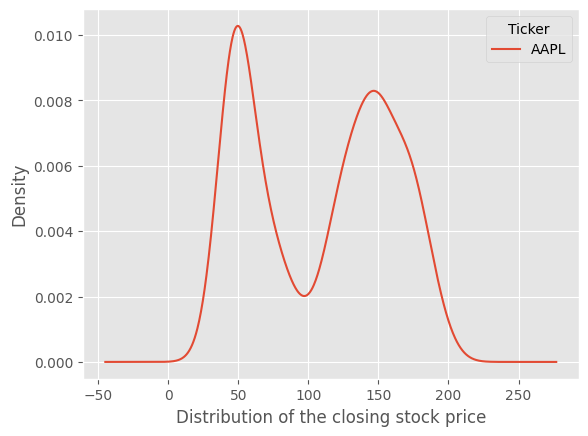

In [ ]:
stock_df['Close'].plot.density()
plt.xlabel('Distribution of the closing stock price')
plt.savefig('../content/Images/den_'+ticker+'.png')
plt.show()

In [ ]:
import pandas as pd
import numpy as np

# Calculate returns
stock_df['Returns'] = stock_df['Close'].pct_change()

# Calculate moving averages
stock_df['MA10'] = stock_df['Close'].rolling(window=10).mean()
stock_df['MA30'] = stock_df['Close'].rolling(window=30).mean()

# Calculate RSI
def calculate_rsi(data, periods=14):
    delta = data.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=periods).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=periods).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

stock_df['RSI'] = calculate_rsi(stock_df['Close'])

# Drop NaN values
stock_df.dropna(inplace=True)

In [ ]:
features = ['Open', 'High', 'Low', 'Close', 'Volume', 'Returns', 'MA10', 'MA30', 'RSI']
X = stock_df[features]
y = stock_df['Close'].shift(-1)  # Predict next day's closing price

# Remove the last row as it will have NaN in y
X = X[:-1]
y = y[:-1]

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
import xgboost as xgb

model = xgb.XGBRegressor(n_estimators=1000, learning_rate=0.01, random_state=42)
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score

y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

Mean Squared Error: 6.263339761830577
R-squared: 0.9974984526634216


<Figure size 1000x600 with 0 Axes>

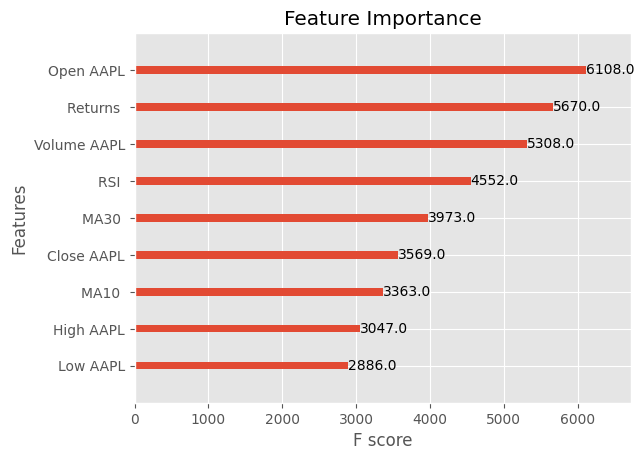

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
xgb.plot_importance(model)
plt.title("Feature Importance")
plt.show()

In [68]:
# Convert columns to appropriate data types
numeric_columns = ['Open', 'High', 'Low', 'Close', 'Volume', 'Returns', 'MA10', 'MA30', 'RSI']

for col in numeric_columns:
    future_df[col] = pd.to_numeric(future_df[col], errors='coerce')

# Fill NaN values that might have been introduced
future_df = future_df.fillna(method='ffill')

<ipython-input-68-64775790954f>:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  future_df = future_df.fillna(method='ffill')


In [70]:
# Update column names to match the training data
future_df.columns = [f'{col} AAPL' if col not in ['Returns', 'MA10', 'MA30', 'RSI'] else f'{col} ' for col in future_df.columns]

In [71]:
# Make predictions for the next 30 days
for i in range(1, 30):
    # Predict the next day's closing price
    X_pred = future_df.iloc[i-1:i]
    y_pred = model.predict(X_pred)

    # Update the future dataframe with the prediction
    future_df.loc[future_df.index[i], 'Close AAPL'] = y_pred[0]
    future_df.loc[future_df.index[i], 'Open AAPL'] = y_pred[0]  # Assume Open price is the same as previous day's Close
    future_df.loc[future_df.index[i], 'High AAPL'] = y_pred[0] * 1.01  # Assume High is 1% above predicted Close
    future_df.loc[future_df.index[i], 'Low AAPL'] = y_pred[0] * 0.99   # Assume Low is 1% below predicted Close
    future_df.loc[future_df.index[i], 'Volume AAPL'] = future_df.iloc[i-1]['Volume AAPL']  # Use previous day's volume

    # Calculate returns
    future_df.loc[future_df.index[i], 'Returns '] = (future_df.iloc[i]['Close AAPL'] - future_df.iloc[i-1]['Close AAPL']) / future_df.iloc[i-1]['Close AAPL']

    # Calculate moving averages
    future_df.loc[future_df.index[i], 'MA10 '] = future_df['Close AAPL'].rolling(window=10).mean().iloc[-1]
    future_df.loc[future_df.index[i], 'MA30 '] = future_df['Close AAPL'].rolling(window=30).mean().iloc[-1]

    # Calculate RSI
    future_df.loc[future_df.index[i], 'RSI '] = calculate_rsi(future_df['Close AAPL'])[-1]

# Ensure all columns are numeric after predictions
for col in future_df.columns:
    future_df[col] = pd.to_numeric(future_df[col], errors='coerce')

# Fill any NaN values that might have been introduced
future_df = future_df.fillna(method='ffill')

<ipython-input-71-847b2325293f>:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  future_df.loc[future_df.index[i], 'RSI '] = calculate_rsi(future_df['Close AAPL'])[-1]
<ipython-input-71-847b2325293f>:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  future_df.loc[future_df.index[i], 'RSI '] = calculate_rsi(future_df['Close AAPL'])[-1]
<ipython-input-71-847b2325293f>:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  future_df.loc[fu

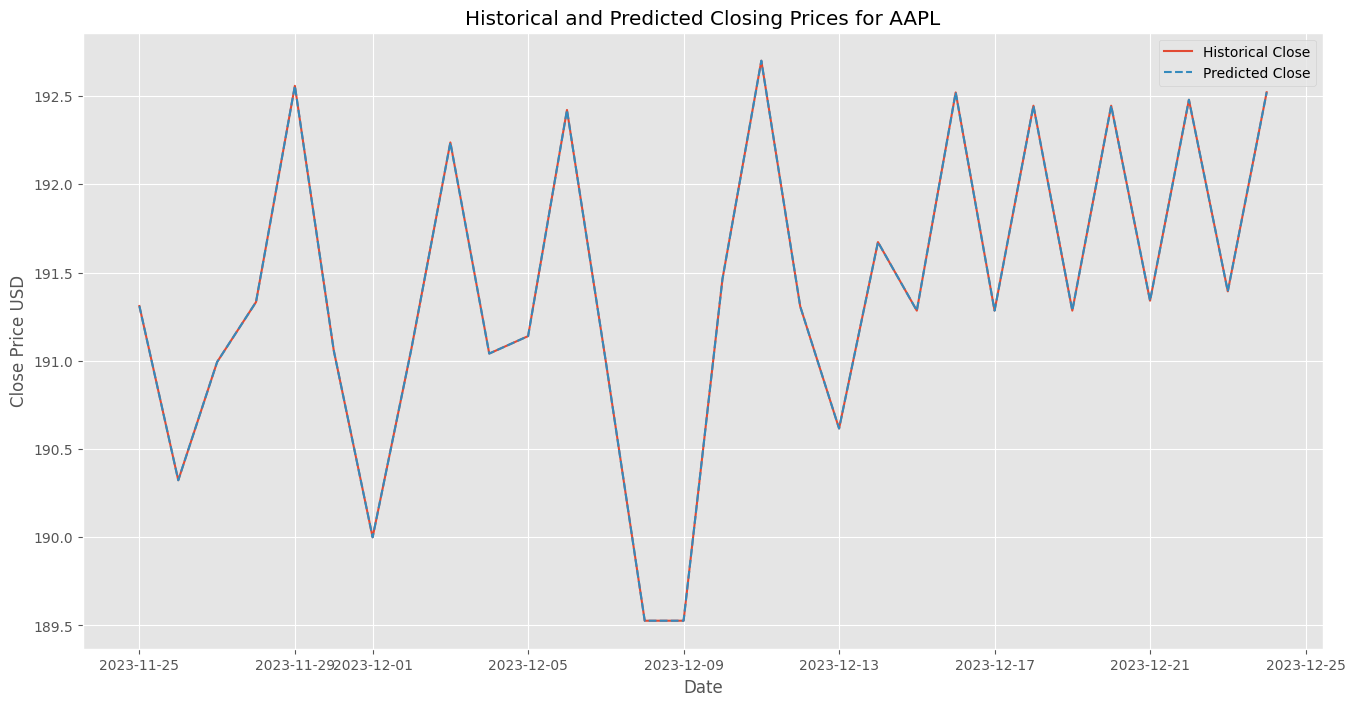


Predicted Closing Prices for the Next 30 Days:
2023-11-25 00:00:00+00:00    191.309998
2023-11-26 00:00:00+00:00    190.322647
2023-11-27 00:00:00+00:00    190.993073
2023-11-28 00:00:00+00:00    191.332611
2023-11-29 00:00:00+00:00    192.558167
2023-11-30 00:00:00+00:00    191.058609
2023-12-01 00:00:00+00:00    189.999344
2023-12-02 00:00:00+00:00    191.070557
2023-12-03 00:00:00+00:00    192.237518
2023-12-04 00:00:00+00:00    191.040665
2023-12-05 00:00:00+00:00    191.139618
2023-12-06 00:00:00+00:00    192.421417
2023-12-07 00:00:00+00:00    190.994095
2023-12-08 00:00:00+00:00    189.526505
2023-12-09 00:00:00+00:00    189.526505
2023-12-10 00:00:00+00:00    191.463348
2023-12-11 00:00:00+00:00    192.700531
2023-12-12 00:00:00+00:00    191.308090
2023-12-13 00:00:00+00:00    190.615921
2023-12-14 00:00:00+00:00    191.672607
2023-12-15 00:00:00+00:00    191.283981
2023-12-16 00:00:00+00:00    192.520920
2023-12-17 00:00:00+00:00    191.283981
2023-12-18 00:00:00+00:00    192

In [72]:
# Combine historical and future data
combined_df = pd.concat([stock_df[['Close']], future_df[['Close AAPL']].rename(columns={'Close AAPL': 'Close'})])

# Plot the results
plt.figure(figsize=(16, 8))
plt.plot(combined_df.index, combined_df['Close'], label='Historical Close')
plt.plot(future_df.index, future_df['Close AAPL'], label='Predicted Close', linestyle='--')
plt.title(f"Historical and Predicted Closing Prices for {ticker}")
plt.xlabel('Date')
plt.ylabel('Close Price USD')
plt.legend()
plt.savefig('../content/Images/prediction_'+ticker+'.png')
plt.show()

# Print the predicted prices
print("\nPredicted Closing Prices for the Next 30 Days:")
print(future_df['Close AAPL'])

In [77]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# Define parameters
ticker = "AAPL"
start_date = "2018-01-01"
end_date = datetime.now().strftime('%Y-%m-%d')

# Download data
stock_df = yf.download(ticker, start=start_date, end=end_date)

print("Shape of df after download:", stock_df.shape)
print(stock_df.head())

[*********************100%***********************]  1 of 1 completed

Shape of df after download: (1732, 6)
Price                      Adj Close      Close       High        Low  \
Ticker                          AAPL       AAPL       AAPL       AAPL   
Date                                                                    
2018-01-02 00:00:00+00:00  40.524338  43.064999  43.075001  42.314999   
2018-01-03 00:00:00+00:00  40.517288  43.057499  43.637501  42.990002   
2018-01-04 00:00:00+00:00  40.705498  43.257500  43.367500  43.020000   
2018-01-05 00:00:00+00:00  41.168930  43.750000  43.842499  43.262501   
2018-01-08 00:00:00+00:00  41.016018  43.587502  43.902500  43.482498   

Price                           Open     Volume  
Ticker                          AAPL       AAPL  
Date                                             
2018-01-02 00:00:00+00:00  42.540001  102223600  
2018-01-03 00:00:00+00:00  43.132500  118071600  
2018-01-04 00:00:00+00:00  43.134998   89738400  
2018-01-05 00:00:00+00:00  43.360001   94640000  
2018-01-08 00:00:00+00:00  

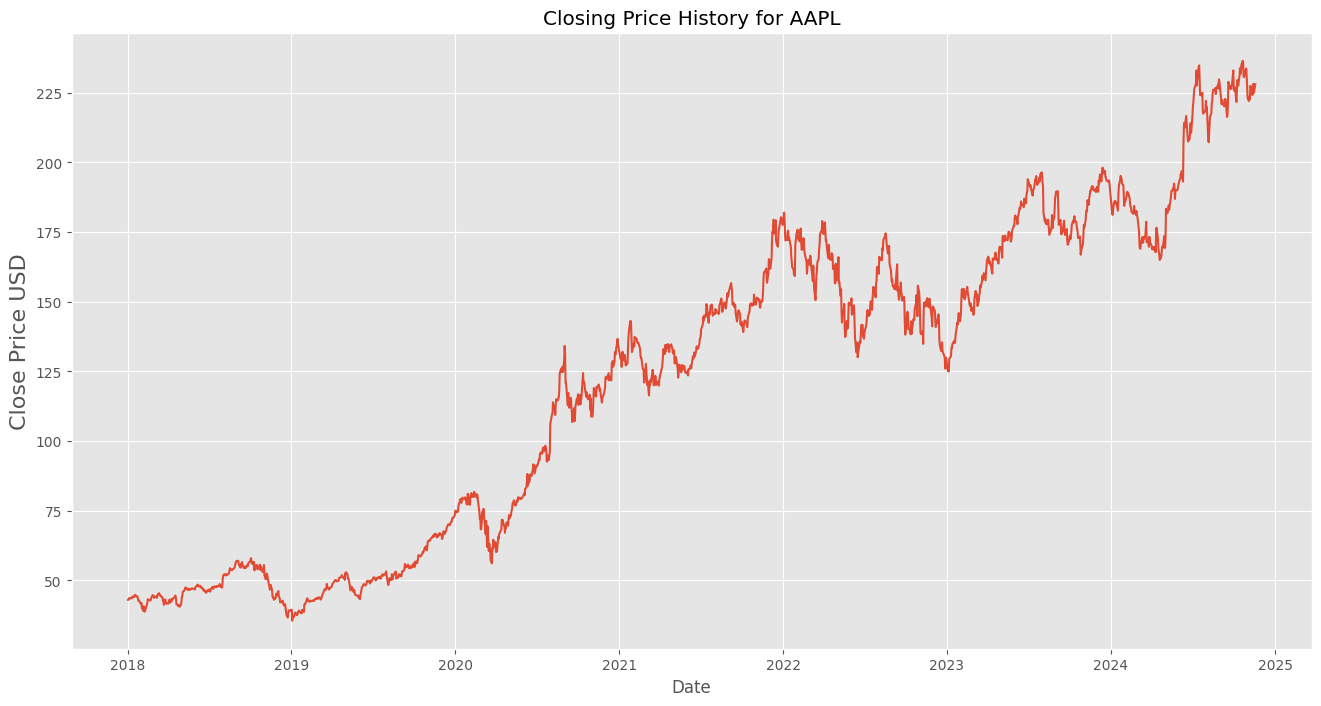

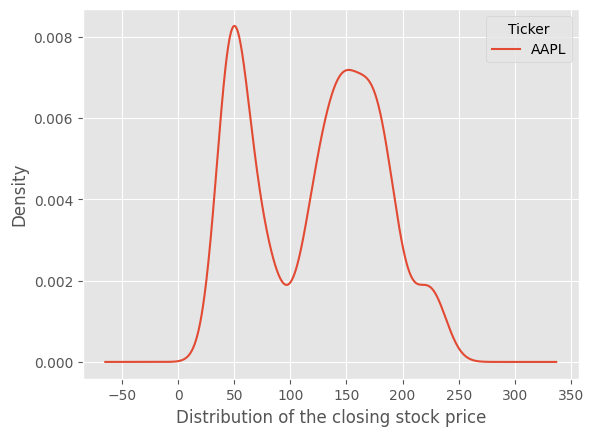

In [78]:
plt.figure(figsize=(16,8))
plt.title(f"Closing Price History for {ticker}")
plt.plot(stock_df['Close'])
plt.xlabel('Date')
plt.ylabel('Close Price USD', fontsize=16)
plt.show()

stock_df['Close'].plot.density()
plt.xlabel('Distribution of the closing stock price')
plt.show()

In [79]:
# Calculate additional features
stock_df['Returns'] = stock_df['Close'].pct_change()
stock_df['MA10'] = stock_df['Close'].rolling(window=10).mean()
stock_df['MA30'] = stock_df['Close'].rolling(window=30).mean()

# Calculate RSI
def calculate_rsi(data, periods=14):
    delta = data.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=periods).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=periods).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

stock_df['RSI'] = calculate_rsi(stock_df['Close'])

# Drop NaN values
stock_df.dropna(inplace=True)

# Prepare features and target
features = ['Open', 'High', 'Low', 'Close', 'Volume', 'Returns', 'MA10', 'MA30', 'RSI']
X = stock_df[features]
y = stock_df['Close'].shift(-1)  # Predict next day's closing price

# Remove the last row as it will have NaN in y
X = X[:-1]
y = y[:-1]

In [80]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train a Random Forest model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train_scaled, y_train)

# Make predictions
y_pred = model.predict(X_test_scaled)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Mean Squared Error: 7.400121268183876
R-squared: 0.997745791126329


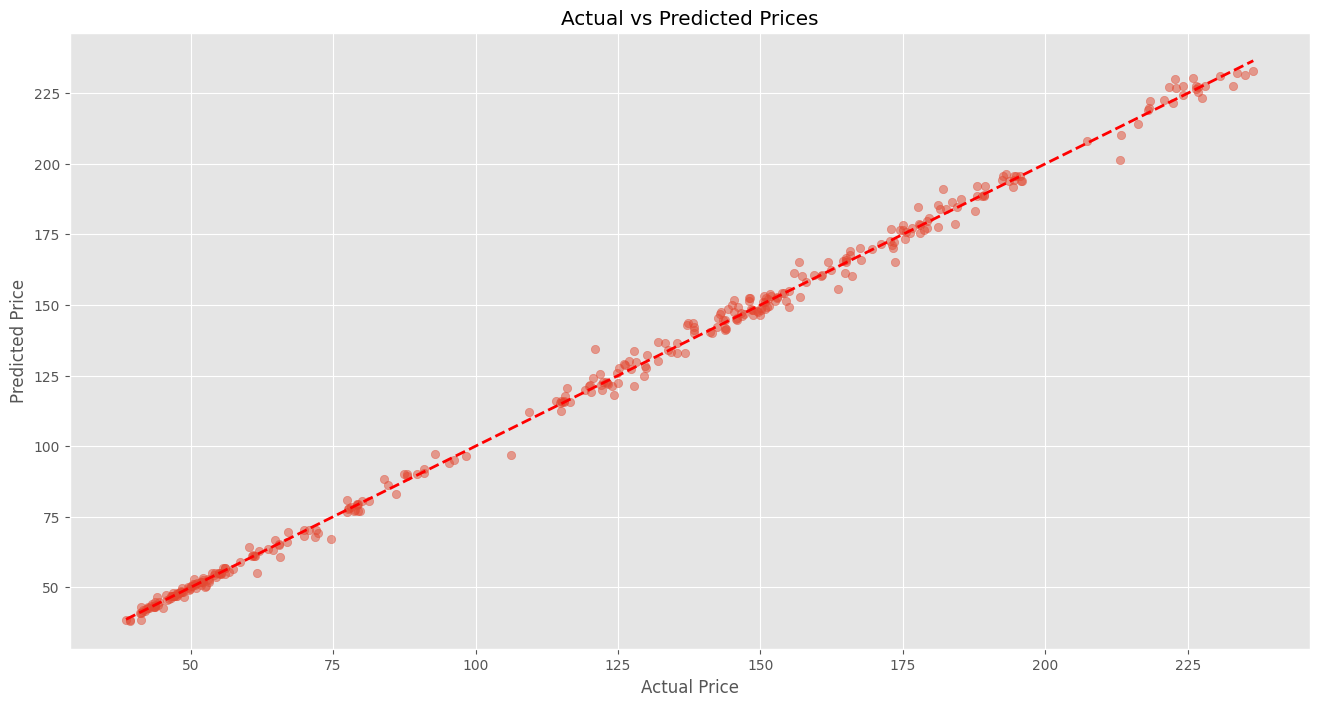

In [81]:
plt.figure(figsize=(16,8))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Actual vs Predicted Prices")
plt.show()